In [3]:
#load modules
print('loading modules...')
import numpy as np

import matplotlib.pyplot as plt

import os

loading modules...


# Firstly, calculate mean of LT * LT (bias terms and scale factor)

In [9]:
def plot_mean_with_error_bars_from_directory_txt(directory_path, nmax):
    """
    Get the mean and standard deviation of binned Cl data from multiple text files in a directory.
    Parameters:
    - directory_path: str, path to the directory containing text files.
    - nmax: int, maximum number of files to process.
    Returns:
    - mean_cl_binned: np.ndarray, mean of the binned Cl data.
    - std_dev_cl_binned: np.ndarray, standard deviation of the binned Cl data
    """
    
    ell_eff_list = []
    cl_binned_list = []

    
    file_names = os.listdir(directory_path)
    NUM = 0 
    data = np.loadtxt(os.path.join(directory_path, file_names[0]))
    
    for file_name in file_names:

        file_path = os.path.join(directory_path, file_name)
        
        cl_binned = np.loadtxt(file_path)

        cl_binned_list.append(cl_binned)
        NUM += 1
        if NUM == nmax:
            break

    mean_cl_binned = np.mean(cl_binned_list, axis=0)
    std_dev_cl_binned = np.std(cl_binned_list, axis=0)

    return mean_cl_binned, std_dev_cl_binned



In [10]:
dlbb_LT_LT_mean,_ = plot_mean_with_error_bars_from_directory_txt('./auto', 500)

In [11]:
np.savetxt('./post_cal/LT_LT_mean.txt', dlbb_LT_LT_mean)

# Secondly, calculate mean of LT * obs (bias terms and scale factor)

In [12]:
dlbb_obs_LT,_ = plot_mean_with_error_bars_from_directory_txt('./cross', 500)

In [13]:
np.savetxt('./post_cal/LT_obs_mean.txt', dlbb_obs_LT)

# Thirdly, calculate mean of obs * obs (bias terms and scale factor)

In [18]:
dlbb_obs_obs,dlbb_obs_obs_std = plot_mean_with_error_bars_from_directory_txt('./obs', 500)

In [20]:
np.savetxt('./post_cal/obs_mean.txt', dlbb_obs_obs)

# Here, combine and save the data vector used for paramter fitting

In [ ]:
import os
import pickle
import numpy as np


# Load the average Cl values from the text files  (bias terms and scale factor)
dlbb_LT_LT_average = np.loadtxt('./post_cal/LT_LT_mean.txt')  
dlbb_LT_obs_average = np.loadtxt('./post_cal/LT_obs_mean.txt')   
dlbb_obs_obs_average = np.loadtxt('./post_cal/obs_mean.txt')    


Nsim = 500  # Number of simulations

suffix_range = range(Nsim)
total_clcls = np.zeros((49, 3, 3))

suffix_lost = [291,283]   # Suffixes that are lost and should be removed from the range
suffix_range = [suffix for suffix in suffix_range if suffix not in suffix_lost]

for suffix in suffix_range:
    data_vec = []

    #LT_LT
    filename1 = os.path.join('./auto', f'all_in_one_{suffix}.dat')
    data_LT = ((np.loadtxt(filename1))[1] - dlbb_LT_LT_average[2] - 2*dlbb_LT_LT_average[4]) / dlbb_LT_LT_average[6]

    #LT_obs
    filename2 = os.path.join('./cross', f'all_in_one_{suffix}.dat')
    data_cross = ((np.loadtxt(filename2))[2]-dlbb_LT_obs_average[3]-dlbb_LT_obs_average[4])/dlbb_LT_obs_average[5]

    
    #obs_obs
    filename3 = os.path.join('./obs', f'all_in_one_{suffix}.dat') 
    dlbb_obs_obs0 = np.loadtxt(filename3)[1]   
    dlbb_obs_obs1 = np.loadtxt(filename3)[7]
    dlbb_obs_obs2 = np.loadtxt(filename3)[4]

    
    data_vec = np.array( [dlbb_obs_obs0, data_cross, data_LT] )
    np.savetxt(f'./post_cal/data_vec_old/data_vec_{suffix}.txt', data_vec)

In [ ]:
# Calculate the average of the data_vec from all files in the directory
data_vec_average_fit,_ = plot_mean_with_error_bars_from_directory_txt('./post_cal/data_vec_old', Nsim)

cl_a_cl_as = []
for l in range(49):
    cl_a_cl_a = np.outer(data_vec_average_fit[:,l], data_vec_average_fit[:,l])
    cl_a_cl_as.append(cl_a_cl_a)


np.savetxt(f'post_cal/data_vec_fit_average_old.txt', data_vec_average_fit)

# Finally, get the covariance matrix of the data vector

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt

def compute_covariance_matrix(
    data_dir,
    nmax=300,
    lbin_slice=None,
    save_prefix="cov_full",
    plot=True,
    block_labels=None,
):
    """
    Compute and visualize full covariance (and correlation) matrix of CMB bandpowers.

    Parameters
    ----------
    data_dir : str
        Directory containing data_vec_i.txt files.
    nmax : int
        Max number of simulation files to read.
    lbin_slice : slice or None
        Slice to select ell bins, e.g. slice(0,7).
    save_prefix : str
        Prefix for saving output files.
    plot : bool
        If True, generate and save correlation matrix figure.
    block_labels : list[str]
        Labels for TT/TE/EE or other blocks (displayed on x/y axes).
    """

    data_list = []
    for i in range(nmax):
        filename = os.path.join(data_dir, f"data_vec_{i}.txt")
        if os.path.exists(filename):
            try:
                arr = np.loadtxt(filename)
                if lbin_slice is not None:
                    arr = arr[:, lbin_slice]
                data_list.append(arr)
            except Exception as e:
                print(f"⚠️ Error reading {filename}: {e}")
        else:
            print(f"⏭️ Missing {filename}")

    if len(data_list) == 0:
        raise RuntimeError("❌ No valid data_vec_x.txt files found!")

    data = np.array(data_list)
    Nsim, nblock, nL = data.shape
    print(f"✅ Loaded {Nsim} simulations, each with {nblock}×{nL} bins.")

    # --- Compute covariance ---
    data_flat = data.reshape(Nsim, -1)
    mean_vec = np.mean(data_flat, axis=0)
    data_centered = data_flat - mean_vec
    cov_full = np.dot(data_centered.T, data_centered) / (Nsim - 1)

    # --- Save outputs ---
    np.savetxt(os.path.join(data_dir, f"{save_prefix}.txt"), cov_full)
    np.savetxt(os.path.join(data_dir, f"{save_prefix}_mean.txt"), mean_vec)
    print(f"💾 Saved covariance to {save_prefix}.txt")

    if not plot:
        return cov_full, mean_vec

    # --- Normalize for plotting ---
    std = np.sqrt(np.diag(cov_full))
    corr_full = cov_full / np.outer(std, std)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(corr_full, origin='lower', cmap='coolwarm', vmin=-1, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Correlation coefficient')

    # --- Grid lines for blocks ---
    for i in range(1, nblock):
        ax.axhline(i * nL - 0.5, color='k', lw=1)
        ax.axvline(i * nL - 0.5, color='k', lw=1)

    # --- Set block labels on axes ---
    if block_labels is None:
        block_labels = [f"Block {i+1}" for i in range(nblock)]

    tick_positions = np.arange(nblock) * nL + nL / 2.0
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(block_labels, fontsize=12)
    ax.set_yticklabels(block_labels, fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    ax.set_title("Full CMB bandpower correlation matrix", fontsize=14)
    #ax.set_xlabel(r"$C^{\mathrm{type}}_{b'b'}$")
    #ax.set_ylabel(r"$C^{\mathrm{type}}_{bb}$")
    plt.tight_layout()

    fig_path = os.path.join(data_dir, f"{save_prefix}_corr.png")
    plt.savefig(fig_path, dpi=200)
    print(f"🖼️ Saved plot to {fig_path}")
    plt.show()

    return cov_full, mean_vec, corr_full


⏭️ Missing /home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/temp_QE_ASL/post_cal/data_vec_old/data_vec_283.txt
⏭️ Missing /home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/temp_QE_ASL/post_cal/data_vec_old/data_vec_291.txt
✅ Loaded 498 simulations, each with 3×5 bins.
💾 Saved covariance to cov_full_l7.txt
🖼️ Saved plot to /home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/temp_QE_ASL/post_cal/data_vec_old/cov_full_l7_corr.png


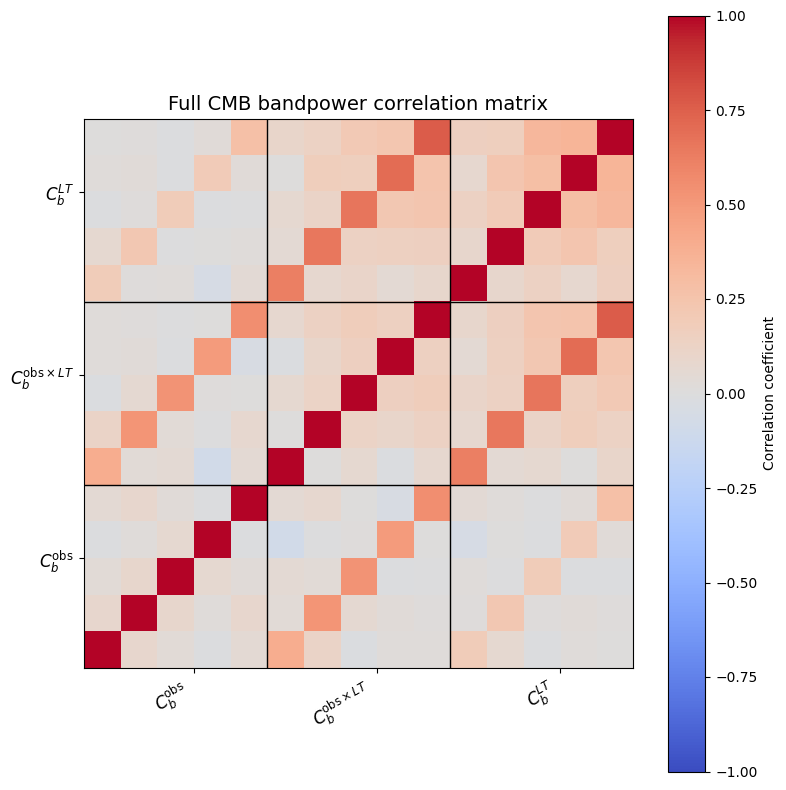

In [26]:
cov, mean, corr = compute_covariance_matrix(
    data_dir="/home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/temp_QE_ASL/post_cal/data_vec_old",
    nmax=500,
    lbin_slice=slice(0, 5),
    save_prefix="cov_full_l7",
    plot=True,
    block_labels=[
        r"$C^{\mathrm{obs}}_{b}$",
        r"$C^{\mathrm{obs}\times LT}_{b}$",
        r"$C^{LT}_{b}$"
    ]
)


In [ ]:
def devide_into_blocks(cov_matrix, nblock, nL, Nsim):
    """
    Devide covariance matrix into blocks.
    Parameters:
    - cov_matrix: np.ndarray, covariance matrix to be divided.
    - nblock: int, number of blocks.
    - nL: int, number of ell bins per block.
    - Nsim: int, number of simulations.
    Returns:
    - cov_blocks: dict, dictionary of covariance blocks.
    """

    p = nblock * nL
    HA_factor = (Nsim - p - 2)/(Nsim - 1)

    cov_blocks = {}
    for i in range(nL):
        for j in range(nL):
            cov_ij = np.zeros((nblock, nblock))
            for bi in range(nblock):
                for bj in range(nblock):
                    cov_ij[bi,bj] = cov_matrix[bi*nL + i, bj*nL + j]
            cov_blocks['({},{})'.format(i, j)] = cov_ij
    return cov_blocks  
    
      
cov_blocks = devide_into_blocks(cov, 3, 5, 500)
corr_blocks = devide_into_blocks(corr, 3, 5, 500)

In [29]:
np.save('./post_cal/cov_blocks.npy', cov_blocks)
np.save('./post_cal/corr_blocks.npy', corr_blocks)